# Pump It Up: Data Mining the Water Table

In [42]:
from scipy import *
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib notebook

In [82]:
## read in data

trainx = pd.read_csv('training_set_values.csv')
trainy = pd.read_csv('training_set_labels.csv')

## Data Exploration

In [171]:
## combine data

train = trainx.merge(trainy, on = 'id')

## verify each id is unique

train['id'].is_unique

True

In [84]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


<IPython.core.display.Javascript object>


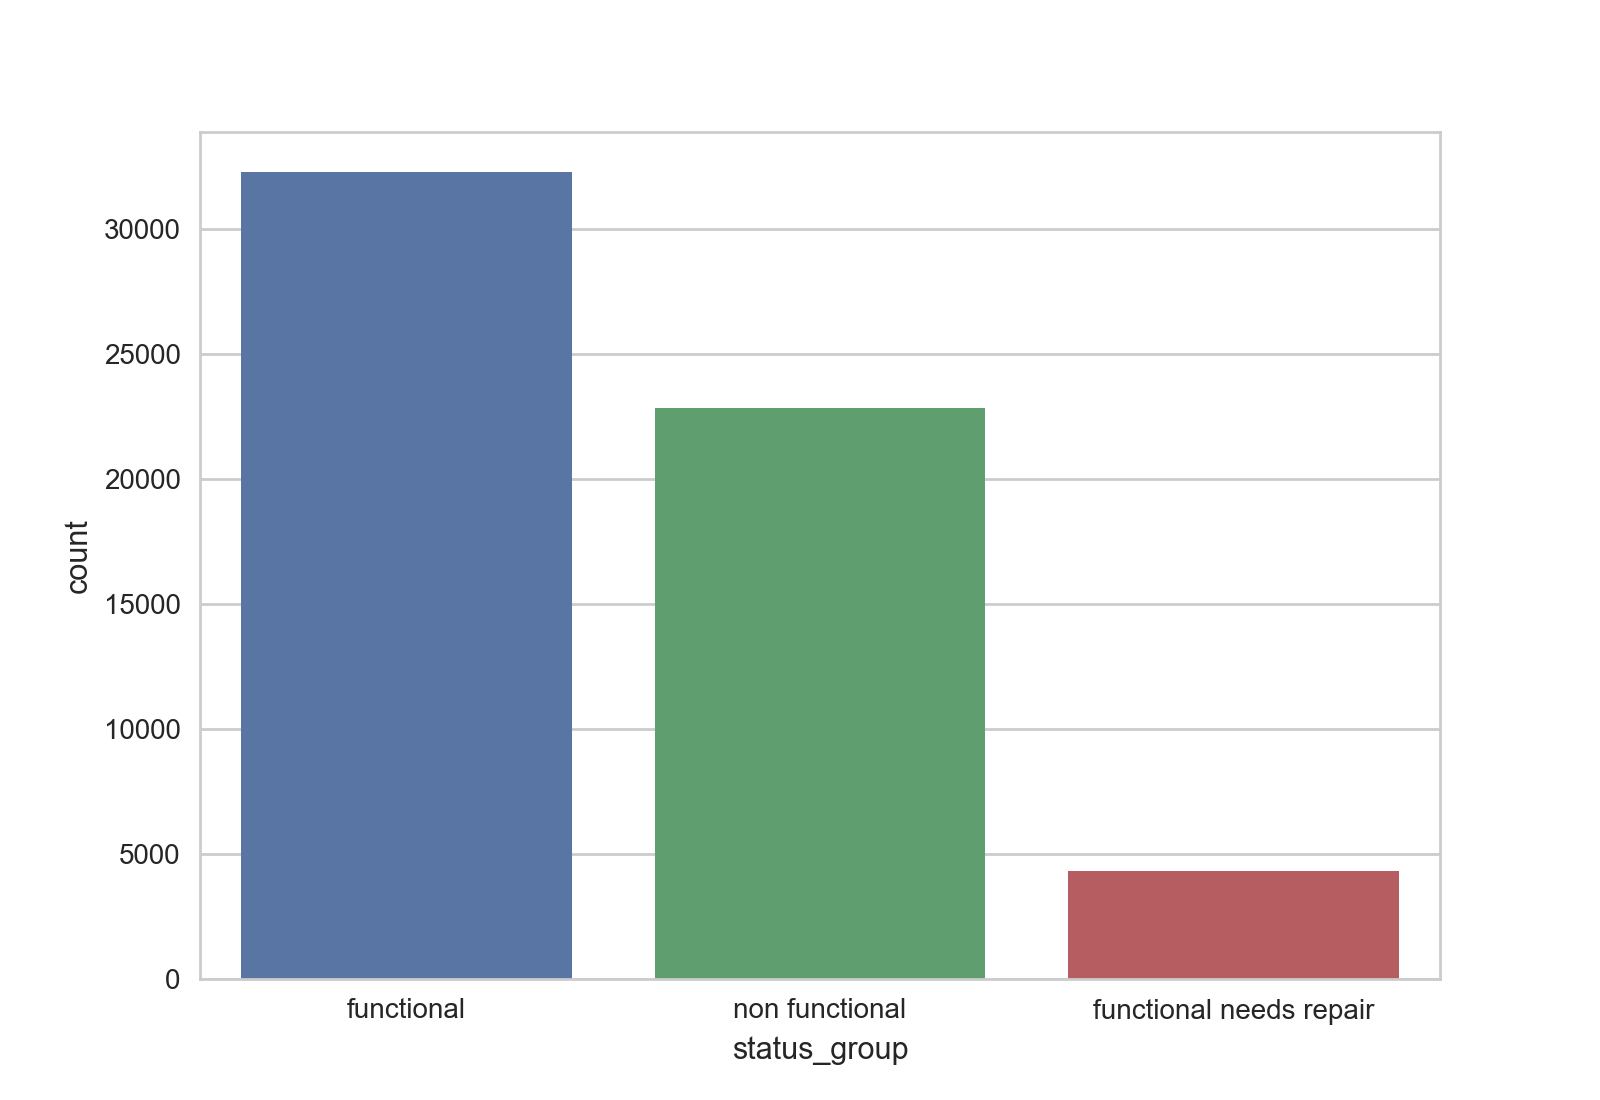

In [185]:
## plot counts for each status
plt.figure()
sns.countplot(train['status_group'])
plt.show()

In [138]:
## pivot table breakdown by variable

dict1 = {'functional':2, 'functional needs repair':1, 'non functional':0} ## dictionary for statuses
train['status_group_count']  = train.status_group.replace(status_listing)
statuses = dict1.values()

piv = train[['water_quality','status_group','status_group_count']]
pt = piv.pivot_table(index = 'water_quality', columns = 'status_group', aggfunc = 'count')
pt

status_group_count                                       
status_group               functional functional needs repair non functional
water_quality                                                               
coloured                        246.0                    54.0          190.0
fluoride                        151.0                    13.0           36.0
fluoride abandoned                6.0                     NaN           11.0
milky                           438.0                    14.0          352.0
salty                          2220.0                   225.0         2411.0
salty abandoned                 174.0                    72.0           93.0
soft                          28760.0                  3904.0        18154.0
unknown                         264.0                    35.0         1577.0

<IPython.core.display.Javascript object>


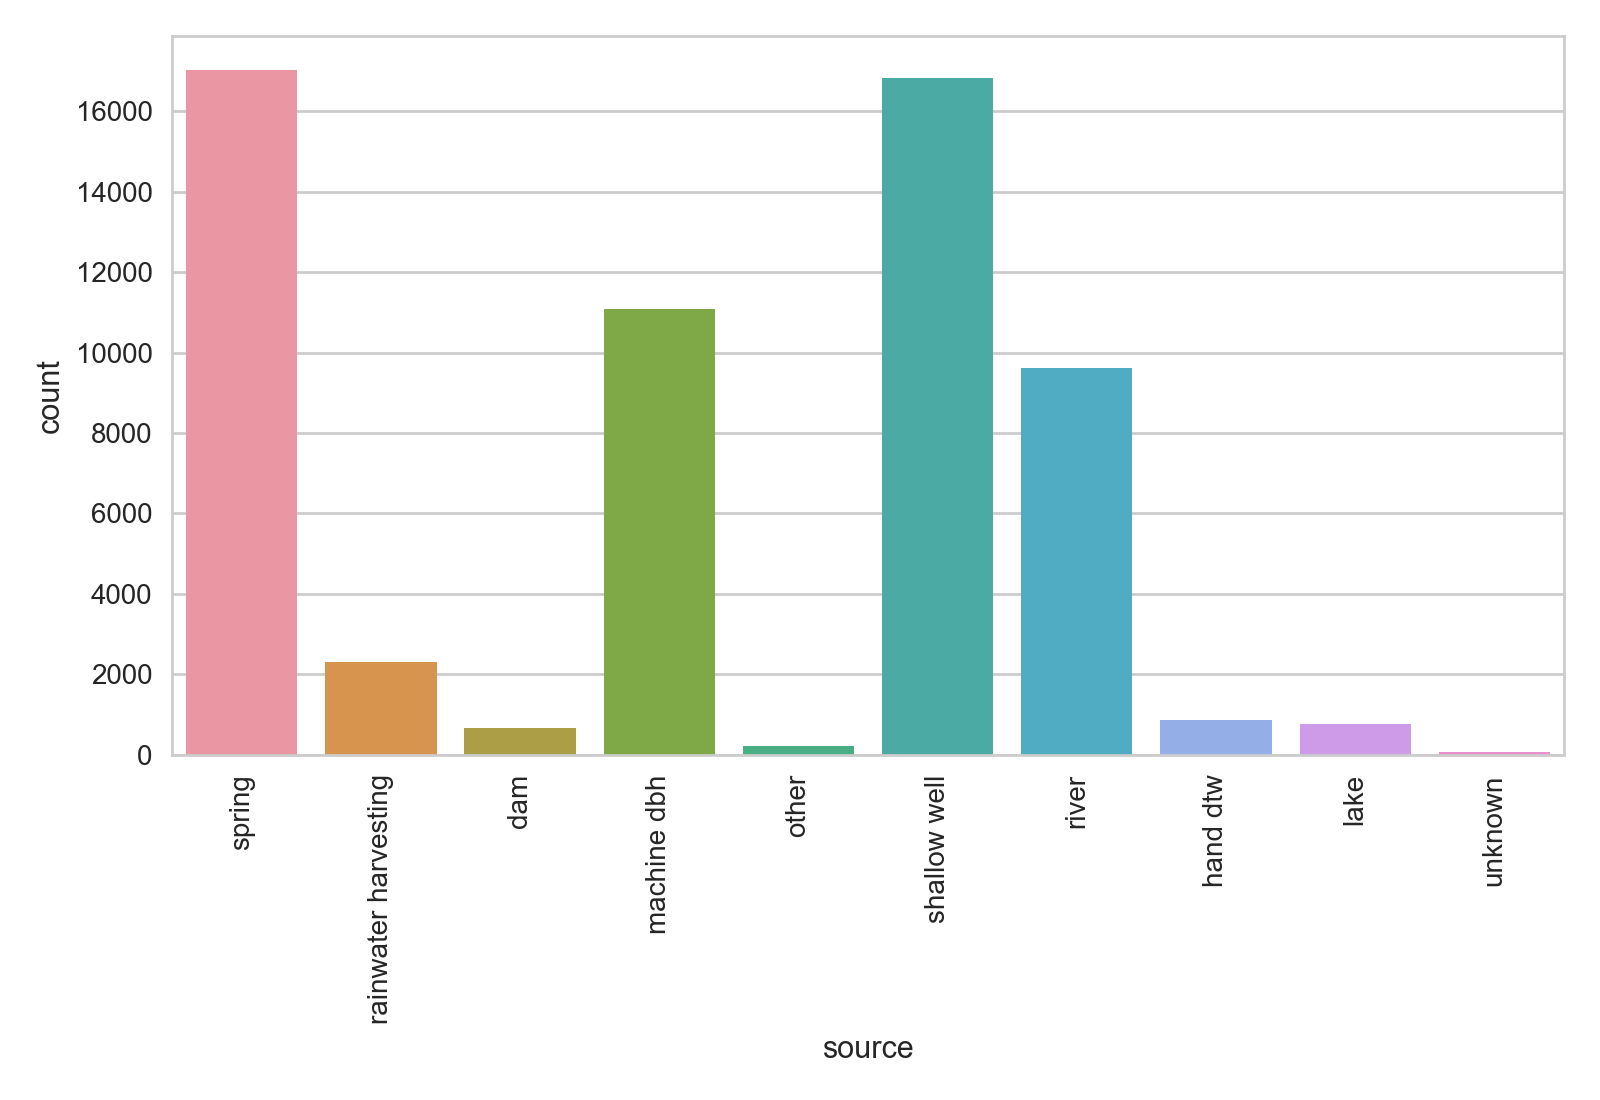

In [188]:
## count breakdown by variable

plt.figure()
sns.countplot(train['source'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [175]:
## converts labels to ints

def stat_int(status_group):
    if status_group == "functional":
        return 2
    elif status_group == "functional needs repair":
        return 1
    else:
        return 0

<IPython.core.display.Javascript object>


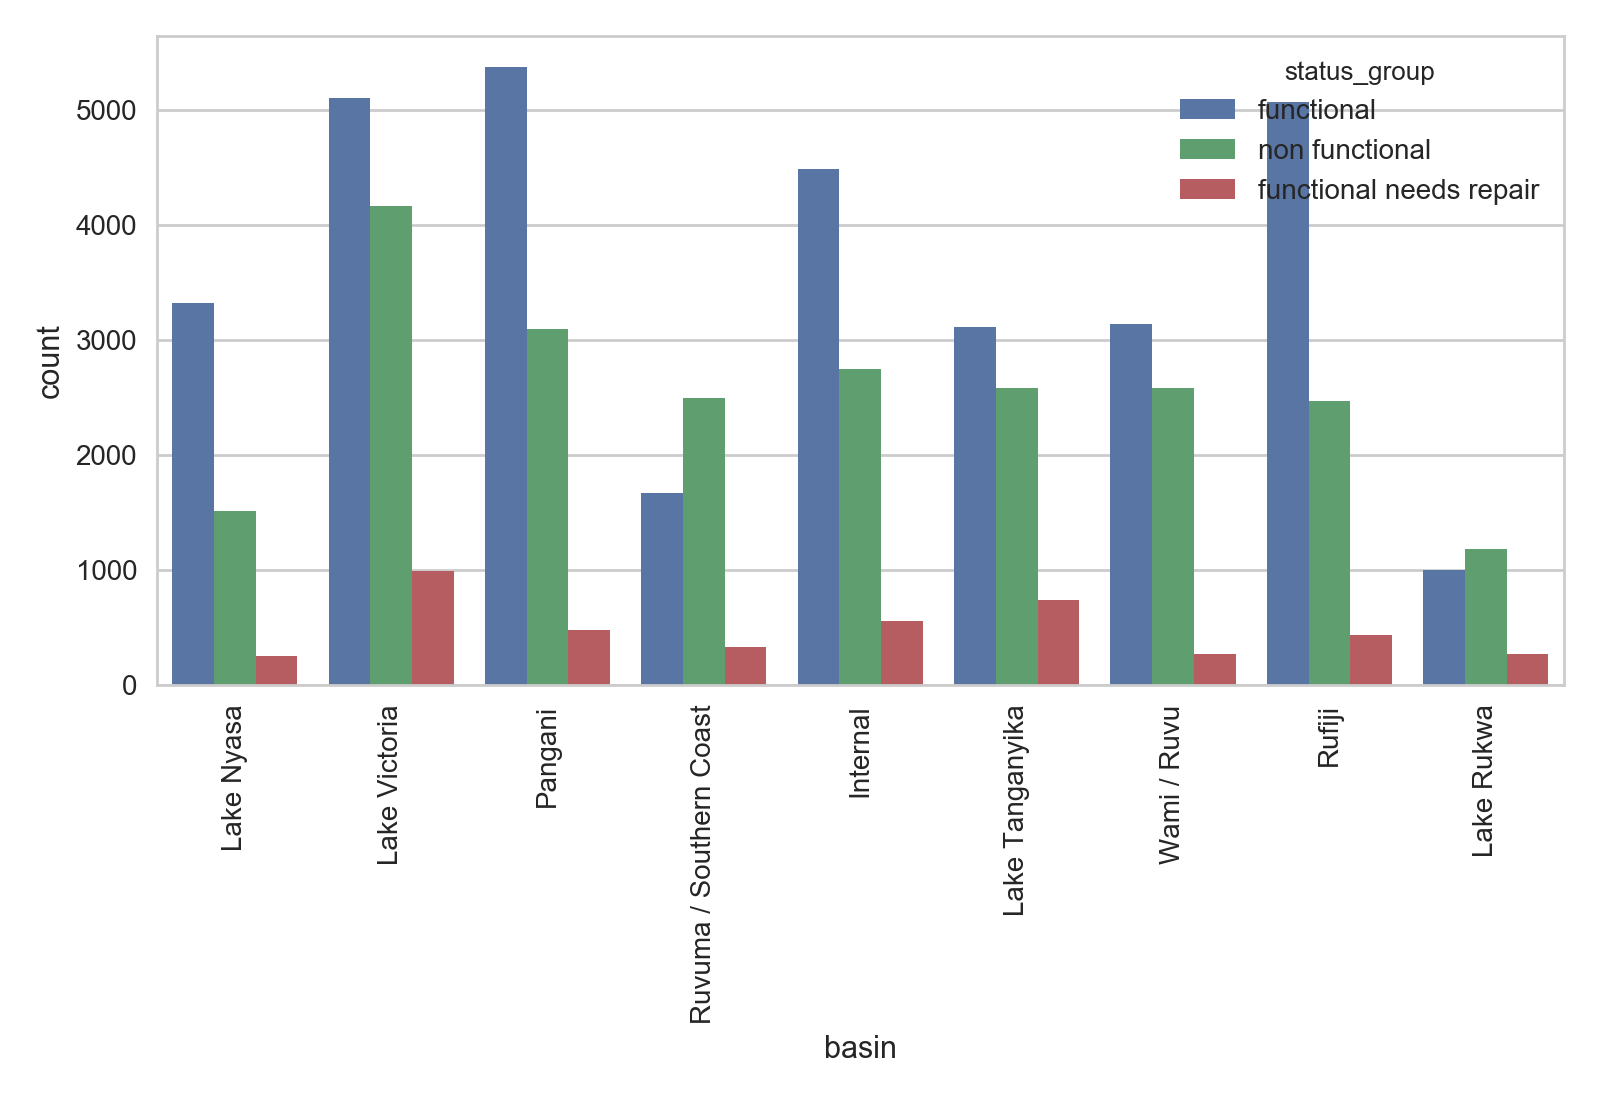

In [183]:
## visualization with status groups

plt.figure()
sns.countplot(train['basin'], hue = train['status_group'])
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [48]:
## percentage of missing values breakdown by variable

((train['permit'] == 0).sum())/((train['permit'].sum()))*100

45.022135282610932

In [49]:
## amount of null for each variable

train.apply(lambda x: sum(x.isnull()))

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

## Data Cleaning

In [93]:
## delete redundant columns

dropped = ['waterpoint_type_group','quantity_group', 'quality_group', 'payment','extraction_type','scheme_name','recorded_by','num_private','source','region_code','district_code']
train.drop(dropped, inplace = True, axis = 1)

In [62]:
## unique values for subvillage 

len(train.subvillage.value_counts()) 

19287

In [94]:
## subvillage getting too specific, drop from df

train = train.drop('subvillage', axis = 1)

In [67]:
train.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [68]:
train.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [95]:
## too similar to 'management', drop

train = train.drop('scheme_management', axis = 1)

In [96]:
## using id as classifier - no need for a name, drop

train = train.drop('wpt_name', axis = 1)

In [71]:
train.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [72]:
train.lga.value_counts()

Njombe              2503
Arusha Rural        1252
Moshi Rural         1251
Bariadi             1177
Rungwe              1106
Kilosa              1094
Kasulu              1047
Mbozi               1034
Meru                1009
Bagamoyo             997
Singida Rural        995
Kilombero            959
Same                 877
Kibondo              874
Kyela                859
Kahama               836
Magu                 824
Kigoma Rural         824
Maswa                809
Karagwe              771
Mbinga               750
Iringa Rural         728
Serengeti            716
Lushoto              694
Namtumbo             694
Songea Rural         693
Mpanda               679
Mvomero              671
Ngara                669
Ulanga               665
                    ... 
Newala               231
Bahi                 224
Kisarawe             223
Temeke               215
Rorya                210
Tarime               209
Ngorongoro           201
Kiteto               193
Shinyanga Urban      191


In [73]:
train.ward.value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
Mishamo             203
Kitunda             203
Msindo              201
Chalinze            196
Maji ya Chai        190
Usuka               187
Ngarenanyuki        172
Chanika             171
Vikindu             162
Mtwango             153
Matola              145
Zinga/Ikerege       141
Maramba             139
Wanging'ombe        139
Itete               137
Magomeni            135
Kikatiti            134
Ifakara             134
Olkokola            133
Maposeni            130
Mvomero             129
Igongolo            129
Mlangali            125
Nkoma               122
Nkungulu            121
                   ... 
Ifinga                1
Themi                 1
Mkumbi                1
Korongoni             1
Mlimani               1
Matarawe              1
Sungwisi              1
Izia                  1
Burungura             1
Linda                 1
Mawenzi         

In [74]:
## appears that ward, lga, and region are all geographic with different degrees of specificity
## recommendation to only keep region, drop lga and ward

In [116]:
train.installer.value_counts()

DWE                          17402
Government                    1825
RWE                           1206
Commu                         1060
DANIDA                        1050
KKKT                           898
Hesawa                         840
0                              777
TCRS                           707
Central government             622
CES                            610
Community                      553
DANID                          552
District Council               551
HESAWA                         539
LGA                            408
World vision                   408
WEDECO                         397
TASAF                          396
District council               392
Gover                          383
AMREF                          329
TWESA                          316
WU                             301
Dmdd                           287
ACRA                           278
World Vision                   270
SEMA                           249
DW                  

In [205]:
train['status_group_val'] = np.where(train['status_group'] == 'functional', '2', np.where(train['status_group'] == 'functional needs repair', '1', '0'))